# Practical Example

## High dimension

The practical example consists of the stable space estimation for a multivariate time series that contains the information of 205 economic indicators since January 2017 

In [1]:
# packages
remove(list = ls())
options(warn = -1)
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)
library(xtable)
suppressMessages(library(GGally))

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

methods_colors <- c("Johansen" = "#fa9f99","PLS" = "#4dcf74", "PCA" = "#90baff") 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Several econonomic indicators in Mexico

In [2]:
# Variables BIE
dt_BIE <- data.table::fread("../databases/variables_BIE.csv")
catalogue_BIE <- data.table::fread("../databases/catalogue_BIE.csv")
# dt_BIE <-dt_BIE[Date < as.Date("2020-01-01")]

We centered the columns of the series, and we get the auxiliary blocks for the methods

In [3]:
X_BIE <- as.matrix(dt_BIE, rownames = "Date")
rownames(X_BIE) <- NULL
X_BIE <- scale(ts(X_BIE))
XX_BIE <- X_BIE[1:(nrow(X_BIE)-1),]
Y_BIE <- X_BIE[2:nrow(X_BIE),]

We check the order of integration of each variable. We count the number of series between the $m$ series that are $\textsf{I}(0)$, $\textsf{I}(1)$ and $\textsf{I}(2)$

In [4]:
aux <- X_BIE

# Step 1: Collect p-values for level, first difference, second difference
pvals_level <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(x)$p.value, error = function(e) NA))
pvals_diff1 <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(diff(x))$p.value, error = function(e) NA))
pvals_diff2 <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(diff(diff(x)))$p.value, error = function(e) NA))

# Step 2: Classify integration order
I0 <- which(pvals_level  > 0.05)
I1 <- which(pvals_level <= 0.05 & pvals_diff1 > 0.05)
I2 <- which(pvals_level <= 0.05 & pvals_diff1 <= 0.05 & pvals_diff2 > 0.05)

# Step 3: Report counts
cat("Number of I(0) series:", length(I0), "\n")
cat("Number of I(1) series:", length(I1), "\n")
cat("Number of I(2) series:", length(I2), "\n")


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Number of I(0) series: 185 
Number of I(1) series: 19 
Number of I(2) series: 1 


We estimate the stable space for this multivariate time series using the methods
- PCA
- PLS

In [5]:
basis_BIE_PLS <- basis_stable(X_BIE, method = "pls")
basis_BIE_PCA <- basis_stable(XX_BIE,method="pca")

We check the estimated stable space dimension

In [6]:
cat("The PLS estimated dimension is: ", ncol(basis_BIE_PLS$basis_S))
cat("\nThe PCA estimated dimension is: ", ncol(basis_BIE_PCA$basis_S))

The PLS estimated dimension is:  191
The PCA estimated dimension is:  199

## Projection Error

We calculate the proyection onto the first two stable components. We also consider the first two principal components.

In [7]:
# PLS
T_scores_PLS <- basis_BIE_PLS$stable_scores 
Y_est_PLS <- scores_rebuilt(T_scores_PLS[,1:2],Y=Y_BIE,method = "PLS")

# PCA
T_scores_PCA <- XX_BIE%*%basis_BIE_PCA$basis_S
Y_est_PCA <- scores_rebuilt(T_scores_PCA[,1:2],Y=Y_BIE)

# PCA with the first two non-stable components
T_scores_PCA_non_stable <- XX_BIE%*%basis_BIE_PCA$basis_N[,1:2]
Y_est_PCA_non_stable <- scores_rebuilt(T_scores_PCA_non_stable[,1:2],Y=Y_BIE)

# PLS with the first two non-stable components
T_scores_PLS_non_stable <- XX_BIE%*%basis_BIE_PLS$basis_N[,1:2]
Y_est_PLS_non_stable <- scores_rebuilt(T_scores_PLS_non_stable[,1:2],Y=Y_BIE)

We could calculate the normalized MSE for each serie

In [8]:
MSE <- matrix(0,ncol(Y_BIE),4) 
colnames(MSE) <- c("PCA non-stable","PCA stationary","PLS non-stable","PLS stationary") ; rownames(MSE) <- colnames(Y_BIE)

# error estimation
MSE[,"PLS stationary"] <- VNMSE_(Y_BIE,Y_est_PLS$est)
MSE[,"PCA stationary"] <- VNMSE_(Y_BIE,Y_est_PCA$est)
MSE[,"PCA non-stable"] <- VNMSE_(Y_BIE,Y_est_PCA_non_stable$est)
MSE[,"PLS non-stable"] <- VNMSE_(Y_BIE,Y_est_PLS_non_stable$est)

Print the results of the estimation using the first two non-stable components and the first two stable components.

In [9]:
print(xtable(MSE[c("s23",head(names(I1),3),names(I2)),],digits = 2))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Wed Jun  4 21:27:39 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & PCA non-stable & PCA stationary & PLS non-stable & PLS stationary \\ 
  \hline
s23 & 0.99 & 0.26 & 0.98 & 0.25 \\ 
  imaief\_Hgo & 0.98 & 0.43 & 0.98 & 0.42 \\ 
  imaief\_SLP & 0.98 & 0.51 & 0.98 & 0.51 \\ 
  s54 & 0.99 & 0.42 & 0.99 & 0.43 \\ 
  rem\_cmenor & 0.98 & 0.17 & 0.99 & 0.17 \\ 
   \hline
\end{tabular}
\end{table}


In [10]:
names(I1)

[1] "imaief_Hgo"                "imaief_SLP"               
 [3] "s54"                       "fbkf"                     
 [5] "fbkf_mqeq"                 "fbkf_mqeq_n_total"        
 [7] "fbkf_mqeq_n_transporte"    "fbkf_mqeq_m_total"        
 [9] "fbkf_mqeq_m_transporte"    "fbkf_mqeq_m_maquinaria"   
[11] "fbkf_construccion"         "fbkf_const_noresidencial."
[13] "vp_enec"                   "po_enec"                  
[15] "horas_enec"                "rem_cmayor"               
[17] "s23"                       "rem_emim"                 
[19] "ventas_veh"

In [11]:
catalogue_BIE[Short %in% c("s23",head(names(I1),3),names(I2))]

Short,Description,Large,SA
<chr>,<chr>,<chr>,<int>
s54,"Servicios profesionales, científicos y técnicos","Indicadores económicos de coyuntura > Indicador global de la actividad económica, base 2018 > Series desestacionalizadas y tendencia-ciclo > Actividades terciarias > 54 Servicios profesionales, científicos y técnicos > Serie desestacionalizada",0
s23,Construcción,"Indicadores económicos de coyuntura > Actividad industrial, base 2018 > Series desestacionalizadas y tendencia-ciclo > Construcción > Total > Serie desestacionalizada",0
imaief_Hgo,Actividad Industrial Hgo,"Indicadores económicos de coyuntura > Actividad industrial por entidad federativa, base 2018 > Series desestacionalizadas y tendencia-ciclo > Total actividad industrial > Hidalgo > Serie desestacionalizada",0
imaief_SLP,Actividad Industrial SLP,"Indicadores económicos de coyuntura > Actividad industrial por entidad federativa, base 2018 > Series desestacionalizadas y tendencia-ciclo > Total actividad industrial > San Luis Potosí > Serie desestacionalizada",0
rem_cmenor,Comercio al por menor Remuneración media,Indicadores económicos de coyuntura > Encuesta mensual sobre empresas comerciales (EMEC). Base 2018 > Series desestacionalizadas y tendencia-ciclo > Comercio al por menor > Remuneración media > Serie desestacionalizada,0


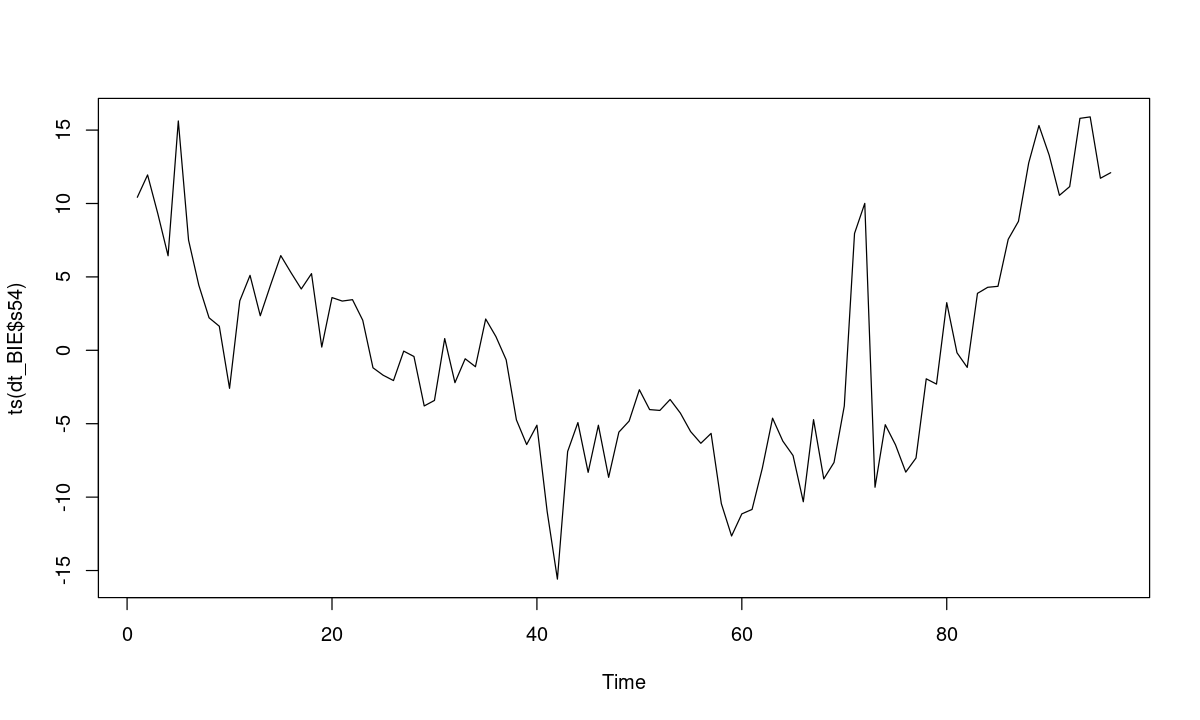

In [12]:
plot(ts(dt_BIE$s54))

We choose two series $\textsf{I}(1)$ for visualisation

In [13]:
options(repr.plot.width = 9, repr.plot.height = 6)

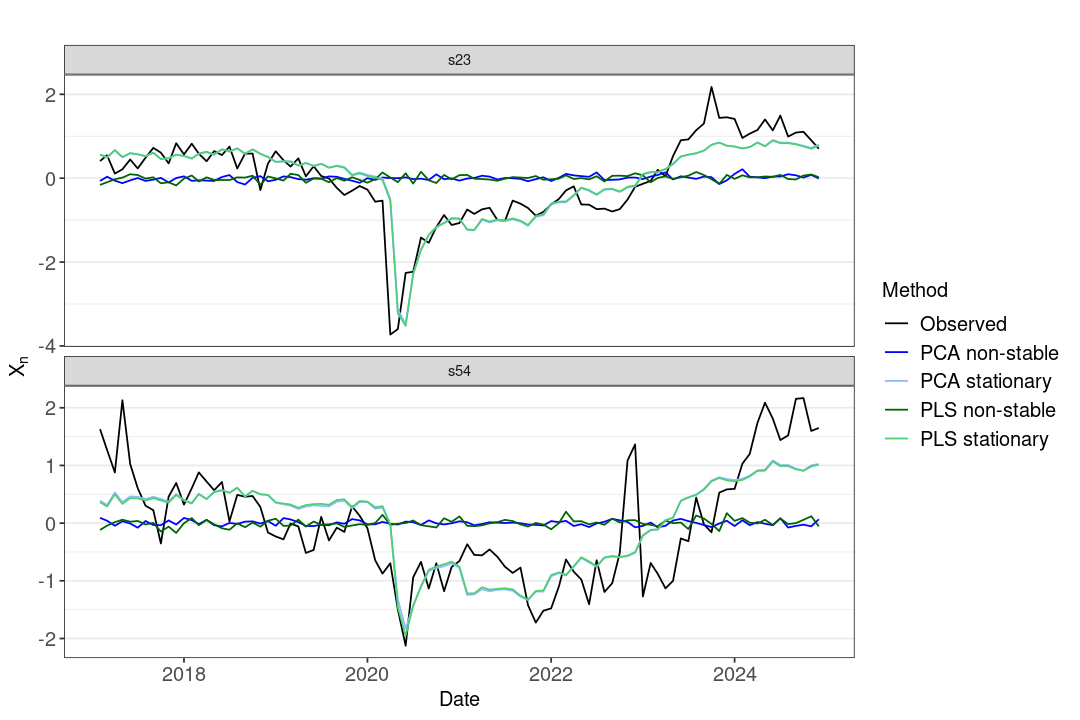

In [14]:
dates <- dt_BIE[,Date][2:nrow(dt_BIE)]
plot_estimates_comparison(
  Y_obs = Y_BIE,
  Y_est_list = list(`PLS stationary` = Y_est_PLS$est, `PCA stationary` = Y_est_PCA$est, `PCA non-stable` = Y_est_PCA_non_stable$est,
  `PLS non-stable` = Y_est_PLS_non_stable$est),
  col_names = c("s23","s54"),
  labels = c("PLS stationary", "PCA stationary","PCA non-stable", "PLS non-stable"),  # optional if list has names
  dates = dates,
  method_palette = c("PLS stationary" = "#4dcf74", "PCA stationary" = "#90baff","Observed" = "black",
                    "PCA non-stable" = "blue", "PLS non-stable" = "darkgreen")
)